In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!python3 -m pip install --upgrade setuptools pip
!python3 -m pip install nvidia-pyindex
#!python3 -m pip install --upgrade nvidia-tensorrt
!python3 -m pip install nvidia-tensorrt==7.2.* --index-url https://pypi.ngc.nvidia.com

In [ ]:
import tensorrt
print(tensorrt.__version__)
assert tensorrt.Builder(tensorrt.Logger())

7.2.3.4


In [ ]:
!git clone https://github.com/NVIDIA/apex.git

In [ ]:
%cd apex
!pip install -v --disable-pip-version-check --no-cache-dir ./
%cd ..

In [ ]:
!sudo apt install libnvinfer* libnvinfer-dev
!pip install torch2trt-unofficial
#%cd ..
!sudo pip3 install tqdm cython pycocotools
!sudo apt-get install python3-matplotlib
!git clone https://github.com/NVIDIA-AI-IOT/trt_pose
%cd trt_pose 
!sudo apt-get install libprotobuf* protobuf-compiler ninja-build
!sudo python3 setup.py install
!python3 setup.py build_ext --inplace


In [ ]:
import json
import trt_pose.coco
import numpy as np
import trt_pose.models
import torch
from torch2trt import torch2trt
from torch2trt import TRTModule
import cv2
import torchvision.transforms as transforms
from PIL import Image
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

pose =  {        'supercategory': 'forklift-person',
                 'id': 1,
                 'keypoints': ['top_front_left',
                               'top_front_right',
                               'top_back_left',
                               'top_back_right',
                               'bot_front_left',
                               'bot_front_right',
                               'bot_back_left',
                               'bot_back_right',
                               'nose',
                               'left_eye',
                               'right_eye',
                               'left_ear',
                               'right_ear',
                               'left_shoulder',
                               'right_shoulder',
                               'left_elbow',
                               'right_elbow',
                               'left_wrist',
                               'right_wrist',
                               'left_hip',
                               'right_hip',
                               'left_knee',
                               'right_knee',
                               'left_ankle',
                               'right_ankle'],
                 'name': 'forklift-person',
                 'skeleton': [[1, 2],
                              [1, 3],
                              [1, 5],
                              [2, 4],
                              [2, 6],
                              [3, 7],
                              [3, 4],
                              [4, 8],
                              [5, 6],
                              [5, 7],
                              [6, 8],
                              [7, 8],
                              [ 9, 10],
                              [ 9, 11],
                              [10, 11],
                              [10, 12],
                              [11, 13],
                              [12, 14],
                              [13, 15],
                              [14, 20],
                              [14, 15],
                              [14, 16],
                              [15, 21],
                              [15, 17],
                              [16, 18],
                              [17, 19],
                              [20, 22],
                              [20, 21],
                              [21, 23],
                              [22, 24],
                              [23, 25]]
                 }

topology = trt_pose.coco.coco_category_to_topology(pose)

In [ ]:
num_parts = len(pose['keypoints'])
num_links = len(pose['skeleton'])

model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()
MODEL_WEIGHTS = '../drive/MyDrive/TRTPose/trained_model/epoch_249.pth'
WIDTH = 224
HEIGHT = 224
data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()


model.load_state_dict(torch.load(MODEL_WEIGHTS))
model_trt = torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)
OPTIMIZED_MODEL = '../drive/MyDrive/TRTPose/trained_model/epoch_249_trt.pth'

torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)
model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')




/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class DrawObjects(object):
    
    def __init__(self, topology):
        self.topology = topology
        
    def __call__(self, image, object_counts, objects, normalized_peaks):
        topology = self.topology
        height = image.shape[0]
        width = image.shape[1]
        K = topology.shape[0]
        count = int(object_counts[0])
        print("count :", count)
        K = topology.shape[0]
        for i in range(count):
            color = (0, 255, 0)
            obj = objects[0][i]
            C = obj.shape[0]
            for j in range(C):
                k = int(obj[j])
                if k >= 0:
                    peak = normalized_peaks[0][j][k]
                    x = round(float(peak[1]) * width)
                    y = round(float(peak[0]) * height)
                    image=cv2.circle(image, (x, y), 3, color, 2)
                    image = cv2.putText(image, str(i) +','+str(j), (x+10, y+10), fontScale=0.3,fontFace=cv2.LINE_AA,color=(255,0,255),thickness = 1)

            for k in range(K):
                c_a = topology[k][2]
                c_b = topology[k][3]
                if obj[c_a] >= 0 and obj[c_b] >= 0:
                    peak0 = normalized_peaks[0][c_a][obj[c_a]]
                    peak1 = normalized_peaks[0][c_b][obj[c_b]]
                    x0 = round(float(peak0[1]) * width)
                    y0 = round(float(peak0[0]) * height)
                    x1 = round(float(peak1[1]) * width)
                    y1 = round(float(peak1[0]) * height)
                    image=cv2.line(image, (x0, y0), (x1, y1), color, 2)
        return image


In [ ]:
parse_objects = ParseObjects(topology, cmap_threshold=0.2, link_threshold=0.5, line_integral_samples=20)
draw_objects = DrawObjects(topology)

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

def execute(image):
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    # test_data1=cmap.numpy()[0]
    # test_data2=paf.numpy()[0]
    # im=np.zeros((224,224))
    # im1=np.zeros((224,224))

    # for j in test_data1:
    #     j=cv2.resize(j,(224,224))*255
    #     im=np.maximum(im,j)

    # for j in test_data2:
    #     j=cv2.resize(j,(224,224))*255
    #     im1=np.maximum(im1,j)
    # im=cv2.merge([im,im,im])
    # im1=cv2.merge([im1,im1,im1])
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    #print(counts)
    draw_objects(image, counts, objects, peaks)
    #image=cv2.UMat.get(image)
    #image=cv2.resize(image,(512,512))
    return image

In [ ]:
from google.colab.patches import cv2_imshow
import os
path = os.listdir('../drive/MyDrive/TRTPose/Extra/merge_data')
for i in path[:5]:
  image=cv2.imread('../drive/MyDrive/TRTPose/Extra/merge_data/'+i)
  image=cv2.resize(image, (224,224))
  image,im,im1=execute(image)
  image=cv2.resize(image,(512,512))
  im=cv2.resize(im,(512,512))
  im1=cv2.resize(im1,(512,512))
  cv2_imshow(image)
  cv2_imshow(im)
  cv2_imshow(im1)

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture('../drive/MyDrive/TRTPose/trained_model/default_12_180s_199.mp4')
result = cv2.VideoWriter('../drive/MyDrive/TRTPose/trained_model/default_12_180s_199_1.mp4', cv2.VideoWriter_fourcc(*'MJPG'), 10, (1024, 1024))

if (cap.isOpened()== False): 
  print("Error opening video stream or file")
a=0
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret == True:
    frame=cv2.resize(frame, (224,224))
    frame=execute(frame)
    frame=cv2.resize(frame, (1024,1024))
    result.write(frame)
    a=a+1
  else: 
    break


cap.release()
result.release()
cv2.destroyAllWindows()

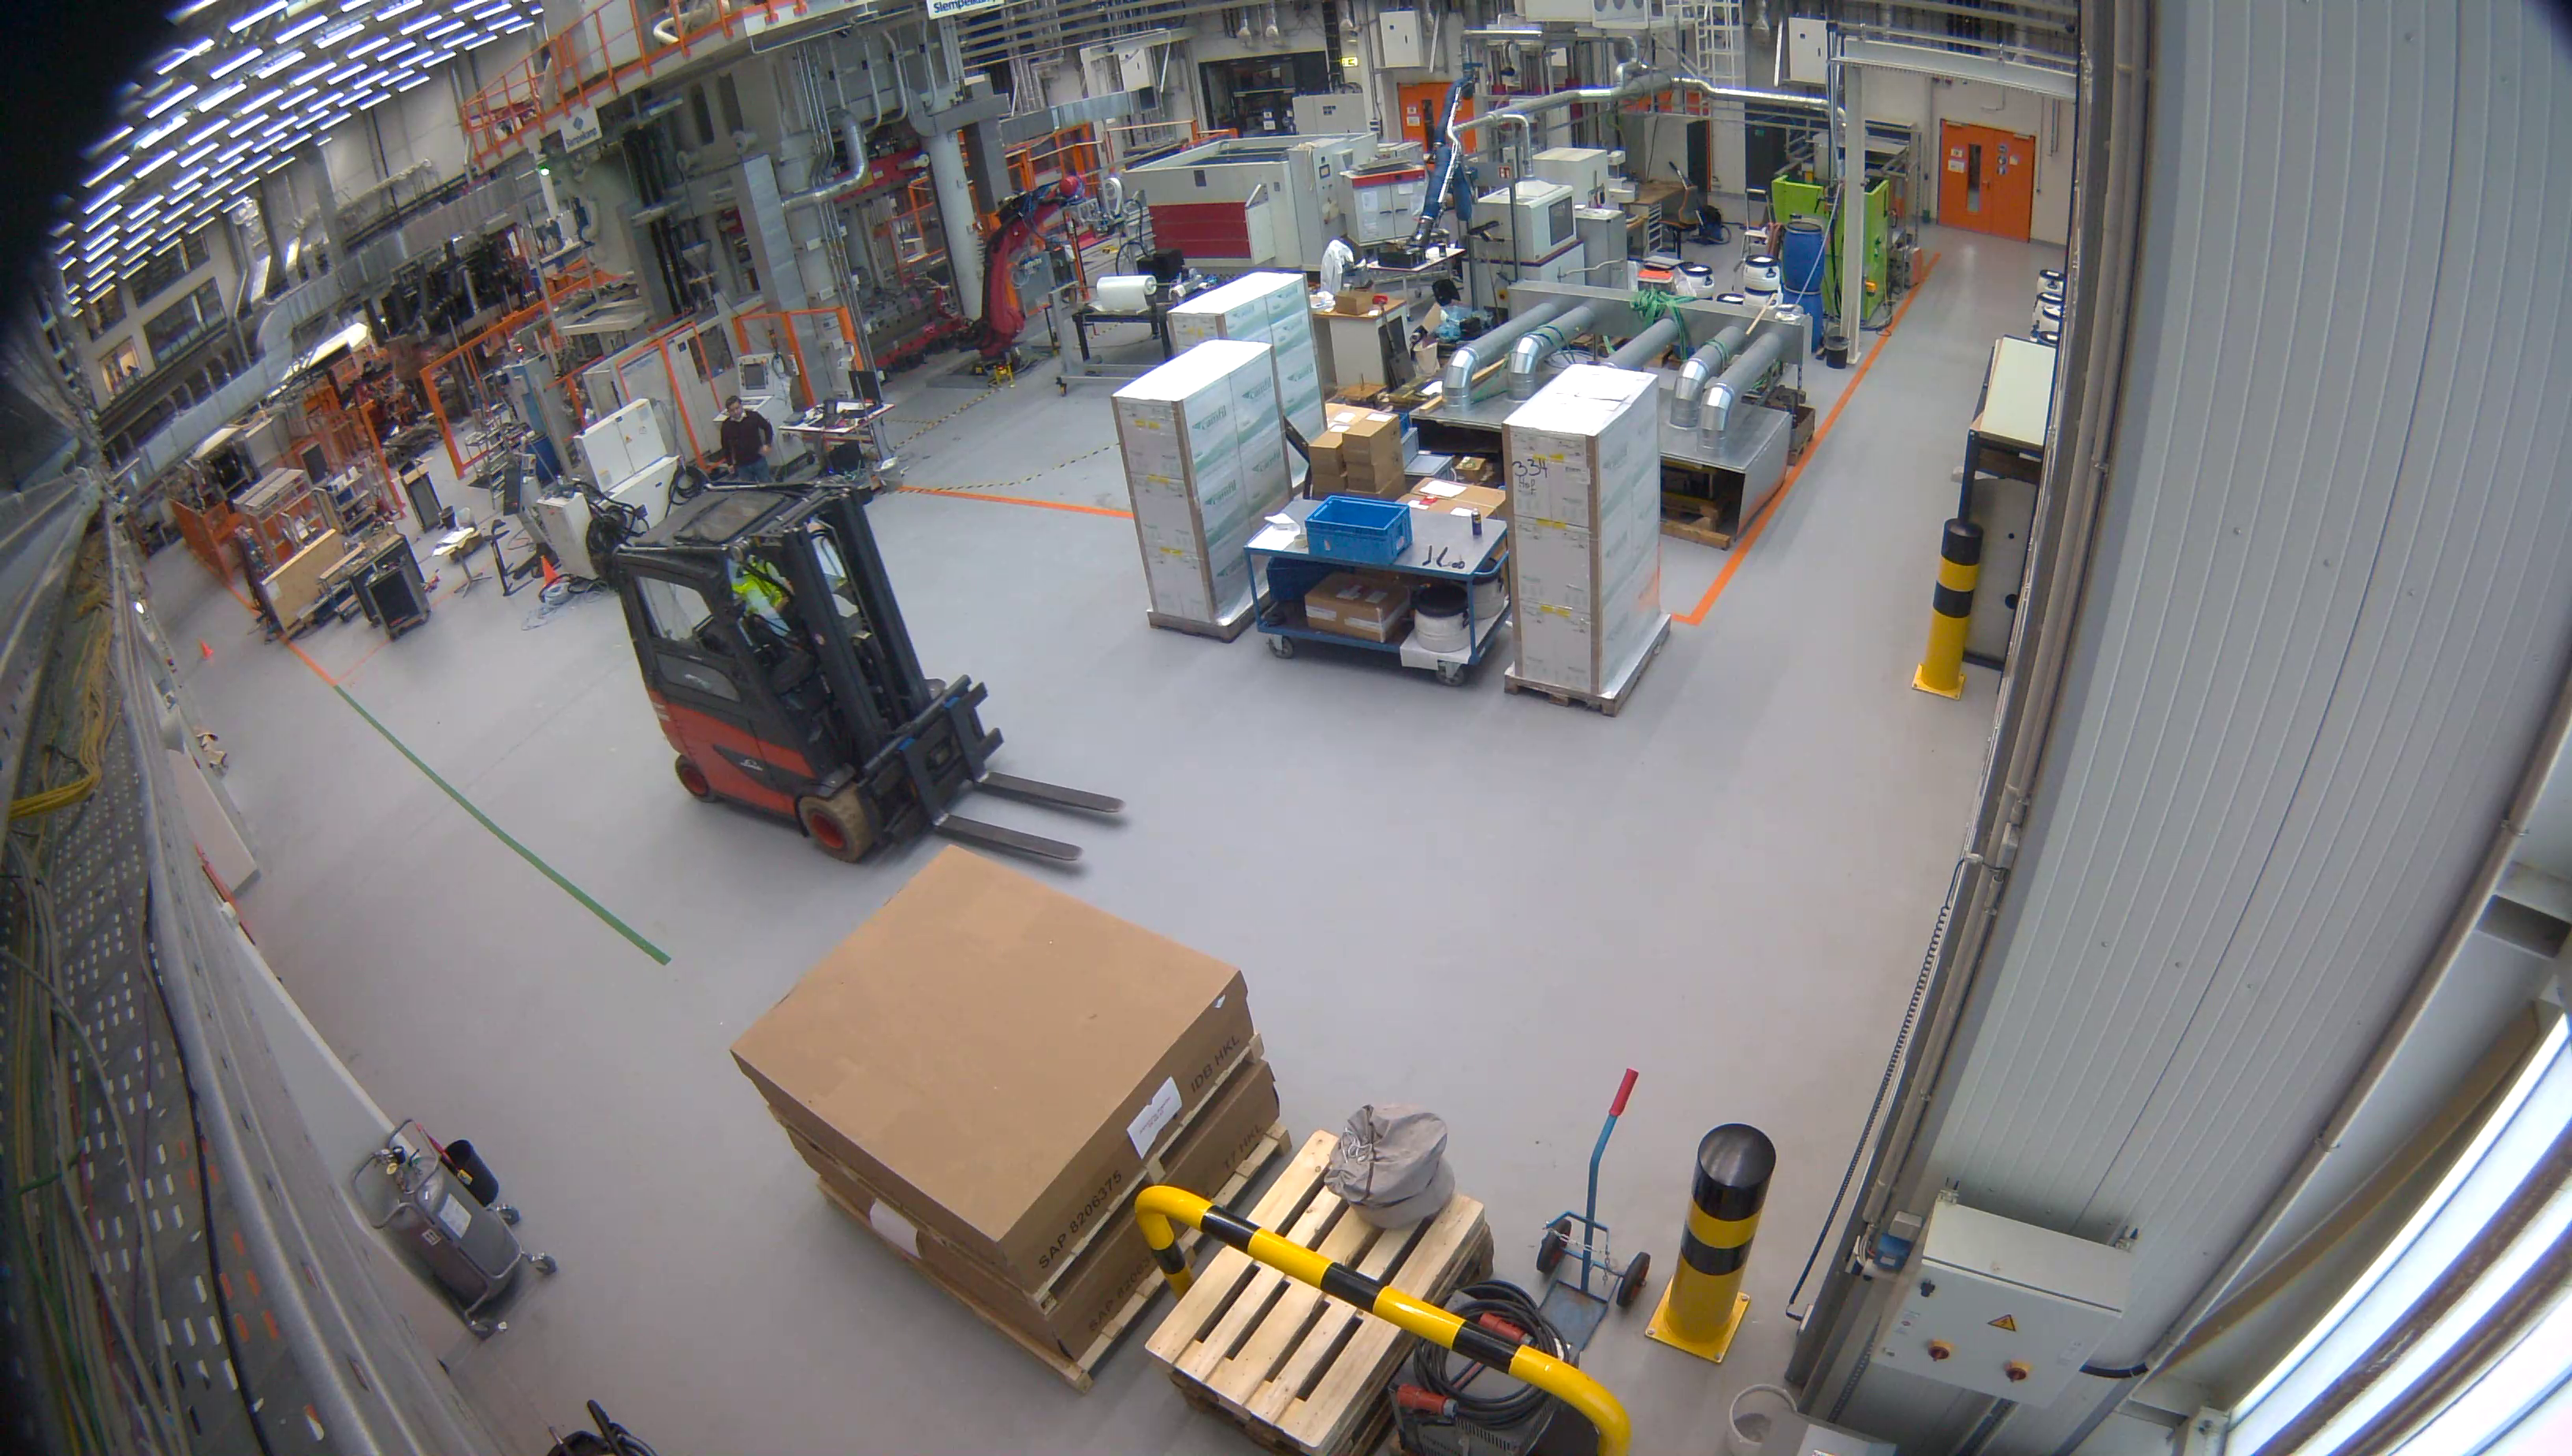

In [ ]:
cv2_imshow(frame)